# Method 1: Using PyStan
We will fit a lorentzian, with the appropriate splitting prescription, in the SNR spectrum.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy import units as u
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411
i = np.deg2rad(56.)
d02 = 6.8
dnu = 102.

Lets take the most central l=1 frequency of our 10 SNR simulated spectrum

In [16]:
locs = np.genfromtxt('locs.txt')
l1 = locs[int(np.floor(len(locs)/2)), 1]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [17]:
sel = [(ff < l1+d02) & (ff > l1-d02)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

I'm using lightkurve here for its smoothing function. I'm not passing the y-axis values appropriately because I can't call a SNRPeriodogram directly. I should probably change that...

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


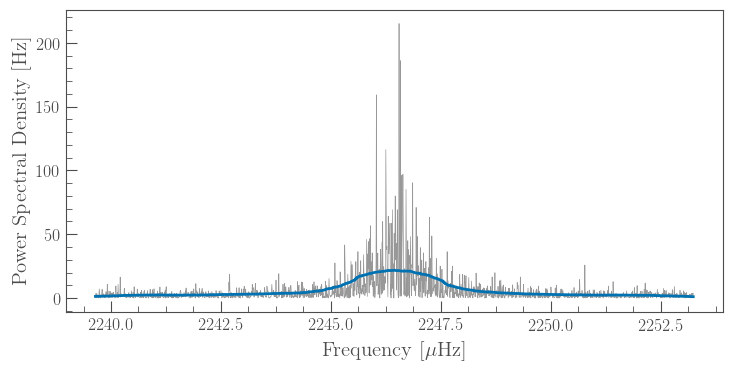

In [18]:
pg = lk.Periodogram(f*u.microhertz, p*u.hertz)
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)

We can see that we have an approximate lorentzian shape. Lets fit to it.

In [19]:
import pystan
model = '''
functions{
    real epsilon(real i, int m){
       if (m == 0){
           return cos(i)^2;
       }
       if (abs(m) == 1){
           return 0.4 * sin(i)^2;
       }
       else return 1.;
    }
    real lor(int m, real f, real eps, real H, real w, real split, real loc){
        return (eps * H) ./ (1 + (4/w^2) * (f - loc + m*split)^2);
    }
    real multiplet(real f, real i, real H, real w, real split, real loc){
        return 1 + lor(-1, f, epsilon(i, -1), H, w, split, loc)
                 + lor(0, f, epsilon(i, 0), H, w, split, loc)
                 + lor(1, f, epsilon(i, 1), H, w, split, loc);
    }
}
data{
    int<lower = 0> N;
    real f[N];
    real p[N];
    real loc;
}
parameters{
    real<lower=0> vsini;
    real<lower=1> H;
    real<lower=0> w;
    real<lower=0> split;
}
transformed parameters{
    real i;
    i = asin(vsini / split);
}
model{
    real beta[N];
    
    for (n in 1:N){
        beta[n] = 1.0 / multiplet(f[n], i, H, w, split, loc);
        p[n] ~ gamma(1, beta[n]);
    }
    
    //priors on the parameters
    i ~ uniform(0., pi()/2);
    H ~ normal(14., 5.);
    w ~ normal(1., 0.5);
    split ~ normal(0.411, 0.1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eeb893e50262db0b2c202074531b9523 NOW.


In [20]:
data = {'N':len(f),
        'f':f,
        'p':p,
        'loc': l1}
init = {'vsini':nus*np.sin(i),
        'H':14,
        'w':1.,
        'split':nus}
fit = sm.sampling(data=data, iter=5000, chains=4, init=[init for i in range(4)])

In [21]:
print(fit)

Inference for Stan model: anon_model_eeb893e50262db0b2c202074531b9523.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vsini   0.07  7.1e-4   0.05 2.5e-3   0.03   0.06    0.1   0.19   5039    1.0
H      22.52    0.03   1.65  19.48  21.37  22.45  23.58  26.04   4154    1.0
w       2.11  1.8e-3   0.11    1.9   2.03   2.11   2.18   2.34   4100    1.0
split   0.41  1.7e-3    0.1   0.22   0.35   0.41   0.48   0.61   3458    1.0
i       0.17  2.0e-3   0.14 5.9e-3   0.07   0.14   0.25   0.52   4841    1.0
lp__   -4177    0.03   1.58  -4181  -4178  -4177  -4176  -4175   2239    1.0

Samples were drawn using NUTS at Thu Mar 21 15:58:59 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


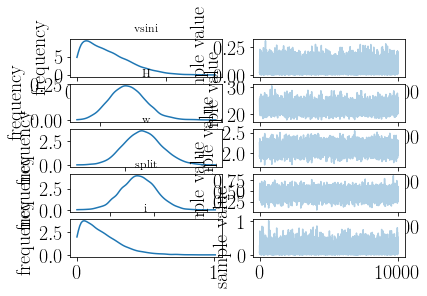

In [22]:
fit.plot()
plt.show()

In [23]:
labels = ['vsini','H','w','split']
params = [np.median(fit[label],axis=0) for label in labels]
p0 = [init[v] for v in init]

In [24]:
def lor(m, f, eps, H, w, split, loc):
    return (eps*H) / (1 + (4/w**2) * (f - loc + m * split)**2)
def multiplet(f, loc, vsini, H, w, split):
    i = np.arcsin(vsini/split)
    return 1 + lor(-1, f, epsilon(i, -1), H, w, split, loc) + \
             lor(0, f, epsilon(i, 0), H, w, split, loc) + \
             lor(1, f, epsilon(i, 1), H, w, split, loc)
def epsilon(i, m):
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.4 * np.sin(i)**2

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


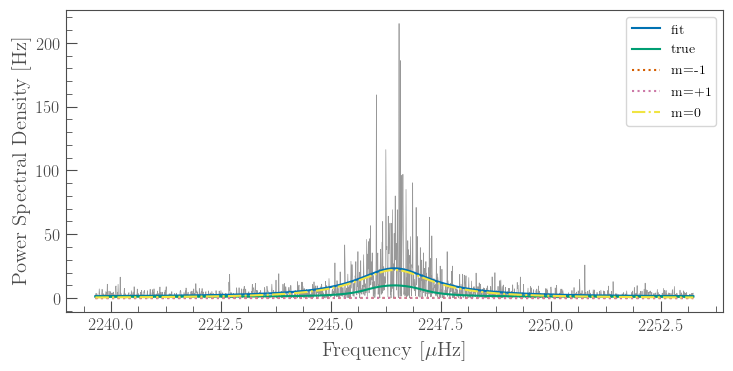

In [25]:
fiti = np.arcsin(params[0]/params[-1])

pg = lk.Periodogram(f*u.microhertz, p*u.hertz)
ax = pg.plot(alpha=.5)
ax.plot(f, multiplet(f, l1, *params), label='fit')
ax.plot(f, multiplet(f, l1, *p0), label='true')
ax.plot(f, lor(-1, f, epsilon(fiti, -1),params[1], params[2], params[3], l1), linestyle=':', label='m=-1')
ax.plot(f, lor(1, f, epsilon(fiti, 1),params[1], params[2], params[3], l1), linestyle=':', label='m=+1')
ax.plot(f, lor(0, f, epsilon(fiti, 0),params[1], params[2], params[3], l1), linestyle='-.', label='m=0')
ax.legend()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


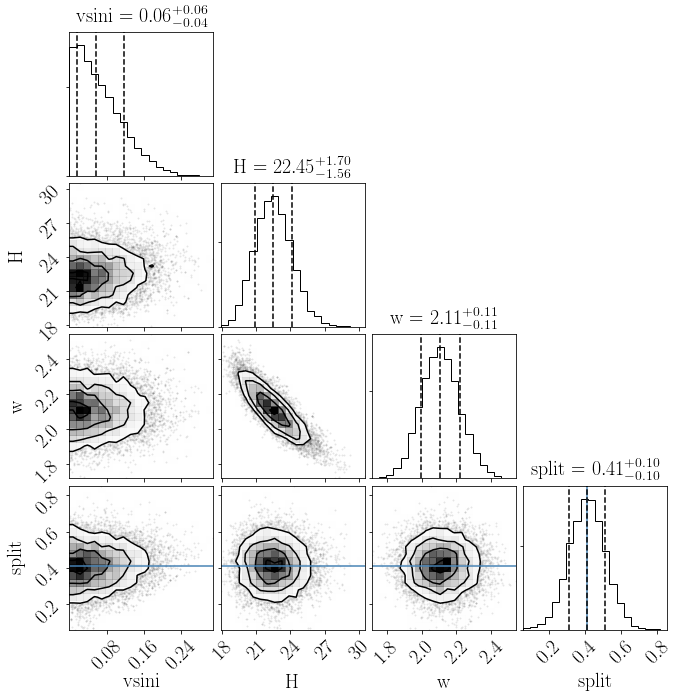

In [26]:
import corner
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, quantiles=[0.16,0.5, 0.84], show_titles=True,
              truths=p0,title_kwargs={"fontsize": 20})
plt.show()

In [27]:
print('The star is rotating at a frequency of: {:.2f} uHz'.format(params[-1]))
print('The star is rotating at a period of: {:.2f} days'.format((1/(params[-1]*u.microhertz)).to(u.day).value))

The star is rotating at a frequency of: 0.41 uHz
The star is rotating at a period of: 28.00 days
